In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/digit-recognizer/train.csv
/kaggle/input/digit-recognizer/test.csv
/kaggle/input/digit-recognizer/sample_submission.csv


# Additional imports

In [2]:
import tensorflow as tf
from tensorflow import keras

import matplotlib.pyplot as plt
import matplotlib.cm as cm

# Preprocessing

In [3]:
train_data_raw = pd.read_csv('/kaggle/input/digit-recognizer/train.csv')
test_data_raw = pd.read_csv('/kaggle/input/digit-recognizer/test.csv')

print('train_data_shape: ' + str(train_data_raw.shape))
print('test_data_shape: ' + str(test_data_raw.shape))

train_data_shape: (42000, 785)
test_data_shape: (28000, 784)


### Pre processing data

In [4]:
def pre_process_data(dataset, has_label=True):
    if has_label:
        data = dataset.iloc[:,1:].values
    else:
        data = dataset.iloc[:,:].values
        
    data = data.astype(np.float)
    
    data = np.multiply(data, 1.0 / 255.0)
        
    return data

train_images = pre_process_data(train_data_raw)

train_images

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

### Pre processing labels

In [5]:
def pre_process_labels(data):
    labels_flat = data.iloc[:,0].values.ravel()
    num_classes = np.unique(labels_flat).shape[0]
    
    num_labels = labels_flat.shape[0]
    index_offset = np.arange(num_labels) * num_classes
    labels_one_hot = np.zeros((num_labels, num_classes))
    labels_one_hot.flat[index_offset + labels_flat.ravel()] = 1

    return labels_one_hot.astype(np.uint8)

train_labels = pre_process_labels(train_data_raw)

print(train_labels)

[[0 1 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 [0 1 0 ... 0 0 0]
 ...
 [0 0 0 ... 1 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 1]]


# Showing data

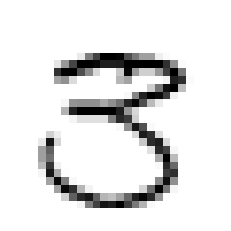

In [6]:
image_size = train_images.shape[1]
image_width = image_height = np.ceil(np.sqrt(image_size)).astype(np.uint8)

def display(img):
    
    # (784) => (28,28)
    one_image = img.reshape(image_width, image_height)
    
    plt.axis('off')
    plt.imshow(one_image, cmap=cm.binary)

display(train_images[7])

In [7]:
print("Images shape: " + str(train_images.shape))
print("Labels shape: " + str(train_labels.shape))

Images shape: (42000, 784)
Labels shape: (42000, 10)


# Model

In [8]:
def fit(train_images, train_labels, config):
    NUM_EPOCHS = config['NUM_EPOCHS']
    BATCH_SIZE = config['BATCH_SIZE']
    LEARNING_RATE = config['LEARNING_RATE']
    DROPOUT_RATE = config['DROPOUT_RATE']
    NETWORK_WIDTH = config['NETWORK_WIDTH']


    model = keras.Sequential([
        keras.layers.Input(shape=(784,)),
        keras.layers.Dense(NETWORK_WIDTH, activation='swish'),
        keras.layers.Dropout(DROPOUT_RATE),
        keras.layers.Dense(NETWORK_WIDTH, activation='swish'),
        keras.layers.Dropout(DROPOUT_RATE),
        keras.layers.Dense(NETWORK_WIDTH, activation='swish'),
        keras.layers.Dropout(DROPOUT_RATE),
        keras.layers.Dense(NETWORK_WIDTH, activation='swish'),
        keras.layers.Dropout(DROPOUT_RATE),
        keras.layers.Dense(NETWORK_WIDTH, activation='swish'),
        keras.layers.Dropout(DROPOUT_RATE),
        keras.layers.Dense(NETWORK_WIDTH, activation='swish'),
        keras.layers.Dropout(DROPOUT_RATE),
        keras.layers.Dense(NETWORK_WIDTH, activation='swish'),
        keras.layers.Dense(NETWORK_WIDTH, activation='tanh'),
        keras.layers.Dense(10)
    ])

    
    opt = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE)
    loss = 'mean_squared_error'

    model.compile(
        optimizer=opt,
        loss=loss,
        metrics=['accuracy']
    )

    
    val_size = int(train_images.shape[0] * 0.2)

    val_images = train_images[:val_size,:]
    val_labels = train_labels[:val_size,:]

    train_images = train_images[val_size:,:]
    train_labels = train_labels[val_size:,:]

    hist = model.fit(
        x=train_images, y=train_labels,
        epochs=NUM_EPOCHS,
        batch_size=BATCH_SIZE,
        validation_steps=10,
        validation_data=(val_images, val_labels),
        verbose=1,
        shuffle=True
    )
    
    loss, acc = model.evaluate(val_images, val_labels)
    
    return model, loss, acc

In [9]:
config = {
    'BATCH_SIZE': 128,
    'LEARNING_RATE': 0.001,
    'DROPOUT_RATE': 0.4,
    'NUM_EPOCHS': 20,
    'NETWORK_WIDTH': 512
}

model, loss, acc = fit(train_images, train_labels, config)

print('Accuracy: ' + str(acc * 100) + '%')

Epoch 1/20
263/263 [==============================] - 8s 31ms/step - loss: 0.0393 - accuracy: 0.8303 - val_loss: 0.0162 - val_accuracy: 0.9352
Epoch 2/20
263/263 [==============================] - 8s 30ms/step - loss: 0.0151 - accuracy: 0.9308 - val_loss: 0.0094 - val_accuracy: 0.9547
Epoch 3/20
263/263 [==============================] - 8s 30ms/step - loss: 0.0106 - accuracy: 0.9465 - val_loss: 0.0071 - val_accuracy: 0.9656
Epoch 4/20
263/263 [==============================] - 8s 29ms/step - loss: 0.0088 - accuracy: 0.9536 - val_loss: 0.0061 - val_accuracy: 0.9656
Epoch 5/20
263/263 [==============================] - 8s 30ms/step - loss: 0.0075 - accuracy: 0.9596 - val_loss: 0.0073 - val_accuracy: 0.9609
Epoch 6/20
263/263 [==============================] - 8s 29ms/step - loss: 0.0070 - accuracy: 0.9619 - val_loss: 0.0048 - val_accuracy: 0.9750
Epoch 7/20
263/263 [==============================] - 8s 31ms/step - loss: 0.0065 - accuracy: 0.9649 - val_loss: 0.0048 - val_accuracy: 0.9727

# Predicting

In [10]:
test_data = pre_process_data(test_data_raw, False)

test_data

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [11]:
predictions = model.predict(test_data)

In [12]:
predictions

array([[ 5.65304607e-03, -3.95392999e-04,  1.02586198e+00, ...,
         2.80941278e-02,  7.69187137e-03, -3.00471392e-03],
       [ 1.11048853e+00, -1.95757616e-02, -5.19108027e-03, ...,
        -3.02324295e-02, -3.72465625e-02, -4.92885988e-03],
       [ 9.51483846e-04,  2.34186836e-03,  1.31195839e-02, ...,
        -1.53425038e-02,  1.84490308e-02,  9.86111045e-01],
       ...,
       [-1.74462907e-02,  5.49597479e-03, -2.54517421e-03, ...,
         3.62050161e-03, -1.73446611e-02, -1.97224319e-02],
       [ 4.80190665e-03,  1.27113797e-03,  1.25542525e-02, ...,
        -1.66599788e-02,  6.15351647e-03,  1.00485468e+00],
       [ 3.98688018e-03, -9.72164795e-04,  1.01826823e+00, ...,
         2.58094519e-02,  7.64657557e-03, -4.29491606e-03]], dtype=float32)

In [13]:
# submissions for Kaggle
submissions=pd.DataFrame({"ImageId": list(range(1,len(predictions)+1)),
                         "Label": np.argmax(predictions, axis=1)})
submissions.to_csv("my_submissions.csv", index=False, header=True)